# Applied Study
***Sean Steinle***

## Table of Contents
1. [Exploring EPA](#Exploring-EPA)
2. [Exploring Potential Predictors](#Exploring-Potential-Predictors)
    - [Yards To Go](#Yards-To-Go)
    - [Yardline](#Yardline)
    - [In Search of a Latent Variable](#In-Search-of-a-Latent-Variable)
3. [A Passable Substitute](#A-Passable-Substitute)
4. [Sampling from EPA](#Sampling-from-EPA)

In this notebook, I'll load and explore the dataset that I'm working with for my applied study: the nflfastR dataset. Specifically, we'll look at the distribution of expected points added (EPA) and any other variables that could serve as good predictors of EPA. Finally, we'll run our adaptive and non-adaptive Metropolis-Hastings algorithms to sample from the EPA distribution given some predictor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#per https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e
YEAR = 2023
nfl_df = pd.read_csv('https://github.com/nflverse/nflverse-data/releases/download/pbp/' \
                   'play_by_play_' + str(YEAR) + '.csv.gz',
                   compression= 'gzip', low_memory= False)

## Exploring EPA

In [3]:
#nflfastR has excellent field descriptions here: https://www.nflfastr.com/articles/field_descriptions.html
nfl_df['epa']

0        0.000000
1        0.000000
2       -0.336103
3        0.703308
4        0.469799
           ...   
49660    1.728891
49661   -0.330699
49662   -0.637115
49663    3.102806
49664         NaN
Name: epa, Length: 49665, dtype: float64

Why is there a Nan?

In [4]:
nfl_df['epa'].isna().sum()

570

In [5]:
nfl_df[nfl_df['epa'].isna()]['desc']

90       END QUARTER 2
174           END GAME
251      END QUARTER 2
341           END GAME
416      END QUARTER 2
             ...      
49282         END GAME
49371    END QUARTER 2
49457         END GAME
49538    END QUARTER 2
49664         END GAME
Name: desc, Length: 570, dtype: object

There are 272 games in a season, so 2 nans per game gets us close to 570. Let's move on!

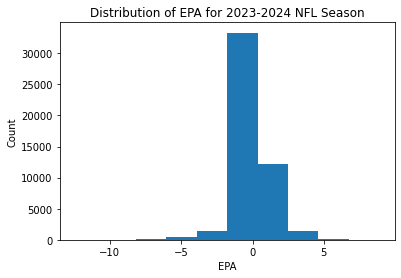

In [6]:
plt.hist(nfl_df['epa'])
plt.xlabel('EPA')
plt.ylabel('Count')
plt.title('Distribution of EPA for 2023-2024 NFL Season')
plt.savefig('../plots/epa_distr_2023.png')

## Exploring Potential Predictors

I hypothesize that there is a predictive relationship between presnap variables that are under the coach's control and the resulting EPA of the play. Let's examine a few of these variables and their relationship to EPA.

### Yards To Go

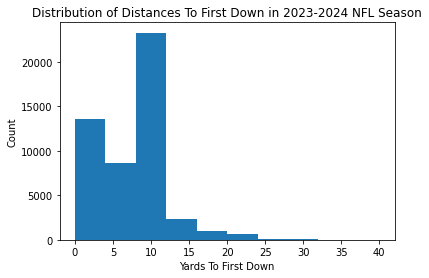

In [7]:
plt.hist(nfl_df['ydstogo'])
plt.xlabel('Yards To First Down')
plt.ylabel('Count')
plt.title('Distribution of Distances To First Down in 2023-2024 NFL Season')
plt.savefig('../plots/distance_2023.png')

(array([10073.,  1687.,  1790.,  1918.,  4519.,  5910., 20673.,  2218.,
          817.,    60.]),
 array([0.        , 0.36888795, 0.73777589, 1.10666384, 1.47555178,
        1.84443973, 2.21332767, 2.58221562, 2.95110356, 3.31999151,
        3.68887945]),
 <BarContainer object of 10 artists>)

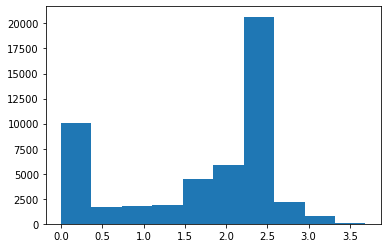

In [8]:
from math import log
log_ydstogo = nfl_df['ydstogo'].apply(lambda x: log(x) if x != 0 else 0.00001)
plt.hist(log_ydstogo)

This is probably one of the better predictors for EPA. It follows an interesting distribution, largely due to a few factors:
- First down always starts at 1st and 10. That's why the mode is particularly large.
- Plays are more often than not, positive. So the only way to get over 10 ydstogo are penalties or lost yards during a play (sacks, tackled for loss, etc.).

In [9]:
nfl_df[['epa','ydstogo']].corr()

,epa,ydstogo
epa,1.000000,-0.023952
ydstogo,-0.023952,1.000000


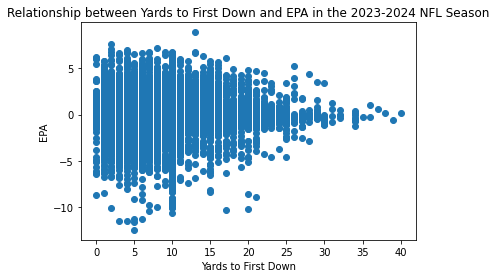

In [10]:
plt.scatter('ydstogo','epa',data=nfl_df)
plt.xlabel('Yards to First Down')
plt.ylabel('EPA')
plt.title('Relationship between Yards to First Down and EPA in the 2023-2024 NFL Season')
plt.savefig('../plots/distance_epa_2023.png')

Interestingly, there isn't a linear correlation between ydstogo and EPA. This is likely because distance is only useful for EPA as a secondary effect--2nd and 1 is great, but 2nd and 1 on your 14 yardline vs. the other team's 8 yardline is a huge difference in play value. Instead of ydstogo, maybe we should use overall field position?

### Yardline

In [11]:
nfl_df[['epa','yardline_100']].corr()

,epa,yardline_100
epa,1.000000,-0.006108
yardline_100,-0.006108,1.000000


Hm, this isn't great either? I wonder why.

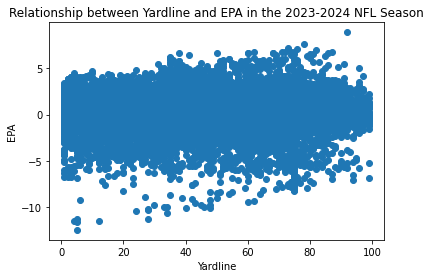

In [12]:
plt.scatter('yardline_100','epa',data=nfl_df)
plt.xlabel('Yardline')
plt.ylabel('EPA')
plt.title('Relationship between Yardline and EPA in the 2023-2024 NFL Season')
plt.savefig('../plots/yardline_epa_2023.png')

Hm, intuition is off! No signal here.

In [13]:
corrs = nfl_df.corr()
epa_corrs = corrs['epa'].dropna()

In [14]:
epa_corrs['pass_attempt']

0.006089244064173143

In [15]:
spread = 20
most_corr = pd.concat([epa_corrs.sort_values().head(int(spread/2)),epa_corrs.sort_values().tail(int(spread/2))])
most_corr

fumble_recovery_2_yards   -0.485512
fumble_recovery_1_yards   -0.343824
interception              -0.333840
third_down_failed         -0.309399
incomplete_pass           -0.255698
fumble_lost               -0.252468
sack                      -0.245817
return_touchdown          -0.233447
fumble_forced             -0.209001
fourth_down_failed        -0.201573
rushing_yards              0.683456
yac_epa                    0.690731
vegas_wpa                  0.715898
receiving_yards            0.748493
passing_yards              0.748531
wpa                        0.751961
lateral_receiving_yards    0.769887
qb_epa                     0.987720
lateral_rushing_yards      0.999960
epa                        1.000000
Name: epa, dtype: float64

Unfortunately, it looks like most of these stats are determined post-snap. This means we will have to train a simple linear model and compose a latent variable which summarizes our presnap predictors.

I should note that this is not unexpected. If there was a golden presnap predictor of postsnap success, we wouldn't have coaches. That's why this problem is worth solving!

### In Search of a Latent Variable

I looked through all ~400 or so variables, and it looks like there are only 5 core pre-snap characteristics that we need to capture:
- **current score** - measured by win probability
- **time remaining** - measured by ordinal rank of series
- **field position** - measured by inverse of yards to opponent endzone
- **down and distance** - measured by yards to first down and down
- **play type** - measured by whether qb drops back
    - It's debatable whether this is a presnap statistic, but even in the case of audibles the playcall is set before the ball is snapped. Things like QB scrambles are really the only scenarios where the play type will change as a result of postsnap dynamics, and I can't think of any other examples of this (a run play never turns into a pass play).
    
Obviously these characteristics will be related in some ways, but the beautiful thing about principal components analysis is that it removes the correlation. Let's try it on these factors.

In [16]:
presnap_df = nfl_df[['wp','series','yardline_100','ydstogo','down','qb_dropback','epa']]
presnap_df.isna().sum()

wp               285
series             0
yardline_100    3460
ydstogo            0
down            7740
qb_dropback     1452
epa              570
dtype: int64

Why so many NaNs for down? Guessing most of these are special teams plays and things of that nature, in which case it'd be fine to drop them. Let's see!

In [17]:
nfl_df[nfl_df['down'].isna()]['desc']

0                                                     GAME
1        5-M.Prater kicks 65 yards from ARI 35 to end z...
26       6-J.Slye extra point is GOOD, Center-54-C.Chee...
27       6-J.Slye kicks 65 yards from WAS 35 to end zon...
32                             Timeout #1 by ARI at 01:43.
                               ...                        
49631    7-H.Butker kicks 65 yards from KC 35 to end zo...
49648    4-J.Moody kicks 65 yards from SF 35 to end zon...
49652                           Timeout #1 by KC at 06:05.
49658                           Timeout #1 by SF at 02:48.
49664                                             END GAME
Name: desc, Length: 7740, dtype: object

Yep! Lot of kickoffs, timeouts, etc.

In [18]:
presnap_df = presnap_df.dropna()
presnap_df

,wp,series,yardline_100,ydstogo,down,qb_dropback,epa
2,0.546262,1,75.0,10,1.0,0.0,-0.336103
3,0.539621,1,72.0,7,2.0,1.0,0.703308
4,0.555987,1,66.0,1,3.0,0.0,0.469799
5,0.572573,2,64.0,10,1.0,1.0,-0.521544
6,0.554537,2,64.0,10,2.0,1.0,1.173155
...,...,...,...,...,...,...,...
49659,0.560584,67,37.0,6,2.0,1.0,0.552538
49660,0.648316,67,32.0,1,3.0,1.0,1.728891
49661,0.857837,68,13.0,10,1.0,0.0,-0.330699
49662,0.849875,68,10.0,7,2.0,1.0,-0.637115


Great, only lost about 8,000 entries as well!

In [19]:
pca_model = PCA(n_components=1)
pca_model.fit(presnap_df.drop('epa',axis=1))
print(pca_model.explained_variance_ratio_)

[0.67217422]


In [20]:
pc_values = pca_model.transform(presnap_df[['wp','series','yardline_100','ydstogo','down','qb_dropback']])
presnap_df['PC1'] = pc_values
presnap_df

,wp,series,yardline_100,ydstogo,down,qb_dropback,epa,PC1
2,0.546262,1,75.0,10,1.0,0.0,-0.336103,-26.258627
3,0.539621,1,72.0,7,2.0,1.0,0.703308,-23.155831
4,0.555987,1,66.0,1,3.0,0.0,0.469799,-16.948915
5,0.572573,2,64.0,10,1.0,1.0,-0.521544,-15.222683
6,0.554537,2,64.0,10,2.0,1.0,1.173155,-15.220454
...,...,...,...,...,...,...,...,...
49659,0.560584,67,37.0,6,2.0,1.0,0.552538,17.465206
49660,0.648316,67,32.0,1,3.0,1.0,1.728891,22.637167
49661,0.857837,68,13.0,10,1.0,0.0,-0.330699,41.288962
49662,0.849875,68,10.0,7,2.0,1.0,-0.637115,44.391756


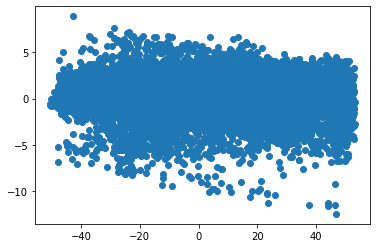

In [21]:
plt.scatter('PC1','epa',data=presnap_df)

Well, doesn't look like this gave us much more signal. Let's see if training a model with all of the relevant presnap statistics does any better.

Simple Linear Regression Coefficients: [ 0.01299439 -0.00140117 -0.00011189 -0.00841403  0.00600705  0.07814995]
Simple Linear Regression Intercept: 0.02635949551352526
MSE: 1.8555693450562398


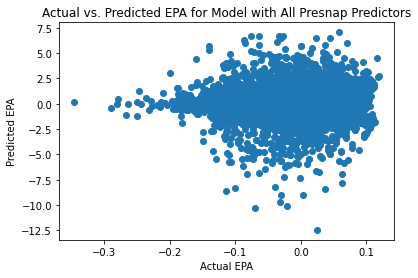

In [29]:
linr = LinearRegression()
X,y = presnap_df.drop(['epa','PC1'],axis=1),presnap_df['epa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linr.fit(X_train,y_train)
print(f"Simple Linear Regression Coefficients: {linr.coef_}\nSimple Linear Regression Intercept: {linr.intercept_}")
preds = linr.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, preds)}")

plt.scatter(preds,y_test)
plt.xlabel('Actual EPA')
plt.ylabel('Predicted EPA')
plt.title('Actual vs. Predicted EPA for Model with All Presnap Predictors')
plt.savefig('../plots/all_presnap_linr.png')

Lasso Coefficients: [ 0. -0. -0. -0.  0.  0.]
Lasso Intercept: -0.0315955902110721
MSE: 1.8603972649576253


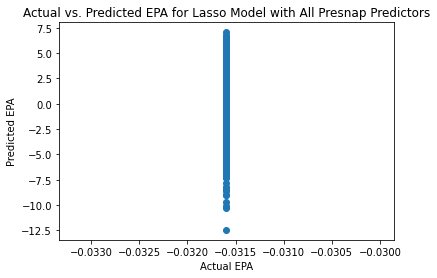

In [23]:
lassr = Lasso()
X,y = presnap_df.drop(['epa','PC1'],axis=1),presnap_df['epa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lassr.fit(X_train,y_train)
print(f"Lasso Coefficients: {lassr.coef_}\nLasso Intercept: {lassr.intercept_}")
preds = lassr.predict(X_test)
mean_squared_error(y_test, preds)
print(f"MSE: {mean_squared_error(y_test, preds)}")

plt.scatter(preds,y_test)
plt.xlabel('Actual EPA')
plt.ylabel('Predicted EPA')
plt.title('Actual vs. Predicted EPA for Lasso Model with All Presnap Predictors')
plt.savefig('../plots/all_presnap_lasso.png')

Even with all of the relevant presnap statistics there is not any signal. We should expect something resembling a diagonal here, but it's mostly a big blob with maybe some sort of horizontal line.

Lasso could have been a nice tool to remove collinearity so we know the best set of variables *with respect to EPA* to reduce, but alas it did not find a useful result.

Given this result, it's hard to imagine a reduced version of this model will do any better. We can then say that **we cannot predict expected points added given presnap statistics**. Instead, we can just use analyze how impactful a post-play factor is in influencing the expected points added statistic.

## A Passable Substitute

When analyzing correlations between EPA and potential predictors, we say that passing yards on the play were strongly correlated (r=~0.75) with EPA. Let's see a visual.

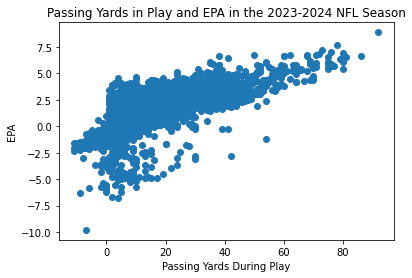

In [28]:
plt.scatter('passing_yards','epa',data=nfl_df)
plt.xlabel('Passing Yards During Play')
plt.ylabel('EPA')
plt.title('Passing Yards in Play and EPA in the 2023-2024 NFL Season')
plt.savefig('../plots/passingyds_epa_2023.png')

## Sampling from EPA

Pardon the code dump, but first we'll need to copy the Metropolis-Hastings implementations over from the simulation study.

In [25]:
import numpy as np
from numpy.random import uniform, normal, multivariate_normal, exponential, gamma
import scipy as sc
from scipy import stats
from statsmodels.tsa.stattools import acf
import pandas as pd
import matplotlib.pyplot as plt

#metropolis-hastings functions
def sample(data: np.ndarray, N: int, B: int, start_theta: tuple, search_breadth: float=0.5, adaptive: bool=False):
    """Takes N samples via the Metropolis-Hastings algorithm, with B burn-in samples."""
    theta, Y = start_theta, []
    for b in range(B): #burnin samples
        if adaptive:
            results = adaptive_step(data, theta, search_breadth, Y)
            theta, Y = results['theta'], results['Y']
        else:
            results = step(data, theta, search_breadth)
            theta = results['theta']
    
    samples = []
    for n in range(N): #real samples
        if adaptive:
            results = adaptive_step(data, theta, search_breadth, Y)
            theta, Y = results['theta'], results['Y']
        else:
            results = step(data, theta, search_breadth)
            theta = results['theta']
        samples.append(results)
    return samples

def step(data: np.ndarray, theta: tuple, search_breadth: float):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = sample_theta(theta, search_breadth) #sample a new set of parameters
    acceptance_log_prob = calc_acceptance_prob(theta, theta_prime, data, search_breadth) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    return {'accepted': accepted, 'acceptance_prob': acceptance_prob, 'theta': theta_prime if accepted else theta} #return results, update theta if samples accepted

def sample_theta(theta: tuple, search_breadth: float):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float):
    """Calculates acceptance log-probability by using a Bayesian linear model. Note: all terms are in log-values here,
    so must be exponentiated before determining acceptance against u."""    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

#bayesian functions
def likelihood(theta: tuple, data: np.ndarray):
    """Calculates the likelihood component of our linear model by measuring our parameters theta on the given data."""
    a,b,sigma = theta
    x,y = data[0],data[1]
    likelihoods = sc.stats.norm.logpdf(y, loc=a*x+b, scale=sigma) #find the likelihood of a sample given a normal distribution specified by our parameters and the data
    return np.sum(likelihoods) #use log likelihood for stability

def prior(theta: tuple):
    """Calculates the prior component of our linear model, specified """
    a,b,sigma = theta
    ab_prior = sc.stats.multivariate_normal.logpdf([a,b], [0,0], [[100,0],[0,100]]) #cov defaults to 1
    sigma_prob = sc.stats.gamma.logpdf(sigma, 1, 1)
    return np.sum([ab_prior,sigma_prob])

def proposal_ratio(theta: tuple, theta_prime: tuple, search_breadth: float):
    """Offsets bidirectionality of chained samples."""
    a,b,sigma = theta
    a_p,b_p,sigma_p = theta_prime
    old_given_new_ab = sc.stats.multivariate_normal.logpdf([a,b],[a_p,b_p],[[search_breadth**2,0],[0,search_breadth**2]])
    old_given_new_sigma = sc.stats.gamma.logpdf(sigma, sigma_p*search_breadth*500, scale=1/(500*search_breadth))
    old_given_new = old_given_new_ab + old_given_new_sigma
    
    new_given_old_ab = sc.stats.multivariate_normal.logpdf([a_p,b_p],[a,b],[[search_breadth**2,0],[0,search_breadth**2]])
    new_given_old_sigma = sc.stats.gamma.logpdf(sigma_p, sigma*search_breadth*500, scale=1/(500*search_breadth))
    new_given_old = new_given_old_ab - new_given_old_sigma

    return old_given_new - new_given_old

#viz functions
def plot_convergence(df: pd.DataFrame):
    """Shows convergence of theta for a given results dataframe."""
    plt.plot(range(len(df)),df['a'], label='slope')
    plt.plot(range(len(df)),df['b'], label='intercept')
    plt.plot(range(len(df)),df['sigma'], label='variance')
    plt.plot(range(len(df)),df['acceptance_prob'], label='accept_prob')
    plt.xlabel("Time Steps")
    plt.ylabel("Values")
    plt.legend()
    
#highest level functions to coordinate runs
def compare_convergences(starting_positions: list, data: np.ndarray, n_samples: int=20000, adaptive: bool=False, out_dir: str=''):
    """High-level function that coordinates many rounds of the Metropolis-Hastings algorithm,
    each starting at a different position."""
    dfs = []
    for start in starting_positions:
        print(f"working on {start}")
        samples = sample(data, n_samples, 0, start, 0.1, adaptive) #no burn-in, breadth of search should be 0.1 -- yields a 5% acceptance rate at convergence

        #aggregate this run's results into dataframe
        df = pd.DataFrame(samples)
        df[['a','b','sigma']] = pd.DataFrame(df['theta'].tolist(), index=df.index)
        df['start'] = str(start) #if this breaks just use an index and map
        df = df.drop(['theta'], axis=1)
        dfs.append(df) #append to the larger results df
        
    df = pd.concat(dfs)
    
    #estimation of parameter over time plots
    for param in ['a','b','sigma']:
        for start_val in df['start'].unique(): #there's definitely a more groupby-y way to do this but this will work!
            param_from_start = df[df['start']==start_val][param]
            plt.plot(range(len(param_from_start)), param_from_start, label=start_val)
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel(param)
        plt.title(f"Evolution of {param.upper()} Parameter Estimate from Different Starts")
        plt.savefig(f'{out_dir}{param}_estimate_evolution_{"adaptive" if adaptive else "nonadaptive"}.jpg', bbox_inches='tight')
        plt.show()
        plt.clf()
        
    #autocorrelation plots (I use the ACF metric from statsmodels, see more here: https://github.com/statsmodels/statsmodels/blob/c22837f0632ae8890f56886460c429ebf356bd9b/statsmodels/tsa/stattools.py#L579)
    lag = n_samples/10
    for param in ['a','b','sigma']:
        for start_val in df['start'].unique(): #there's definitely a more groupby-y way to do this but this will work!
            param_from_start = acf(df[df['start']==start_val][param],nlags=lag)
            plt.plot(range(len(param_from_start)), param_from_start, label=start_val)
        plt.legend()
        plt.xlabel('Time Step')
        plt.ylabel(f'Autocorrelation with Lag {lag}')
        plt.title(f"Autocorrelation for {param.upper()} Parameter Estimate from Different Starts")
        plt.savefig(f'{out_dir}{param}_autocorrelation_{"adaptive" if adaptive else "nonadaptive"}.jpg', bbox_inches='tight')
        plt.show()
        plt.clf()
        
    df.to_csv(f'{out_dir}results.csv')
    return df

#adaptive metropolis-hastings functions (Python NEEDS multiple dispatch!)
def adaptive_step(data: np.ndarray, theta: tuple, search_breadth: float, Y: list):
    """Takes one step in the Metropolis-Hastings algorithm by generating a new theta and comparing to a given theta."""
    theta_prime = adaptive_sample_theta(theta, search_breadth, Y) #sample a new set of parameters
    acceptance_log_prob = adaptive_calc_acceptance_prob(theta, theta_prime, data, search_breadth, Y) #calculate the probability of acceptance
    acceptance_prob = min(1,np.exp(acceptance_log_prob))
    accepted = acceptance_prob >= uniform() #probabilistically determine acceptance
    if accepted:
        theta = theta_prime
        Y.append(theta_prime)
    return {'accepted': accepted, 
            'acceptance_prob': acceptance_prob,
            'theta': theta,
            'Y': Y}

def adaptive_sample_theta(theta: tuple, search_breadth: float, Y: list):
    """Samples theta parameters--slope, intercept, and standard deviation."""
    a,b,sigma = theta
    a,b = multivariate_normal([a,b], [[search_breadth**2,0],[0,search_breadth**2]])
    sigma = gamma(sigma*search_breadth*500, 1/(search_breadth*500))
    theta = a,b,sigma
    return theta

def adaptive_calc_acceptance_prob(theta: tuple, theta_prime: tuple, data: np.ndarray, search_breadth: float, Y: list):
    """Calculates acceptance log-probability by using a Bayesian linear model. Note: all terms are in log-values here,
    so must be exponentiated before determining acceptance against u."""
    avg_accepted_theta = (0,0,1)
    if len(Y) > 0:
        accepted_a,accepted_b,accepted_sigma = zip(*Y)
        avg_accepted_theta = (np.mean(accepted_a),np.mean(accepted_b),np.mean(accepted_sigma))
    
    theta_likelihood = likelihood(theta, data)
    theta_prior = prior(avg_accepted_theta) if len(Y) > 0 else prior(theta)
    
    theta_p_likelihood = likelihood(theta_prime, data)
    theta_p_prior = prior(theta_prime)
    
    pr = proposal_ratio(theta, theta_prime, search_breadth)
    acceptance_ratio = theta_p_likelihood - theta_likelihood + theta_p_prior - theta_prior + pr
    return acceptance_ratio

working on (0, 0, 1)
working on (5, 20, 1.5)
working on (10, 40, 2)
working on (20, 80, 5)


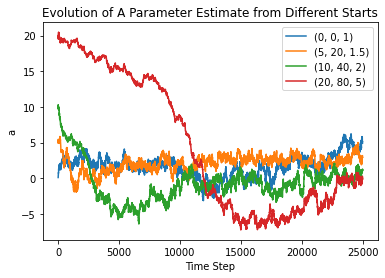

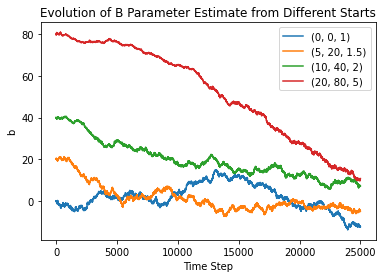

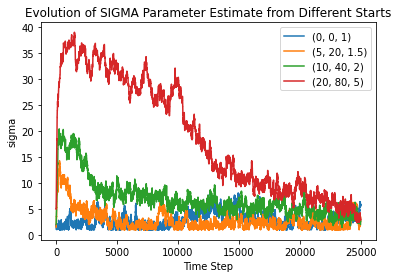

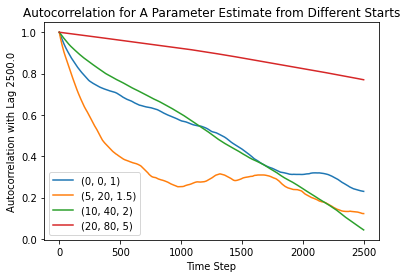

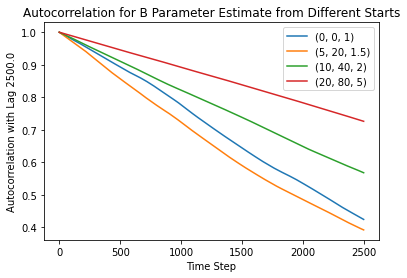

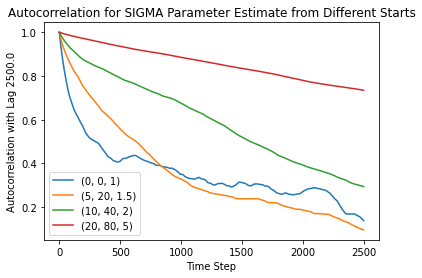

<Figure size 432x288 with 0 Axes>

In [26]:
data = nfl_df[['passing_yards','epa']].dropna().to_numpy()
nonadaptive_df = compare_convergences([(0,0,1),(5,20,1.5),(10,40,2),(20,80,5)], data, 25000, False, '../results/applied_study/notebook/')

working on (0, 0, 1)
working on (5, 20, 1.5)
working on (10, 40, 2)
working on (20, 80, 5)


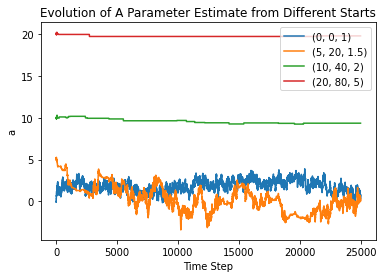

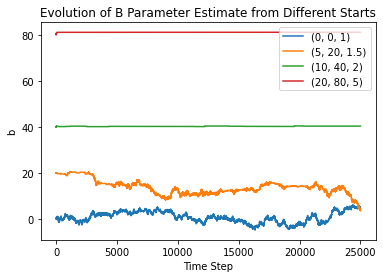

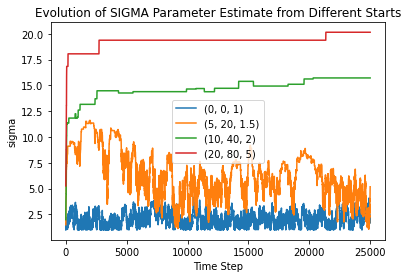

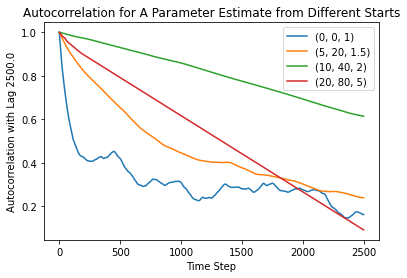

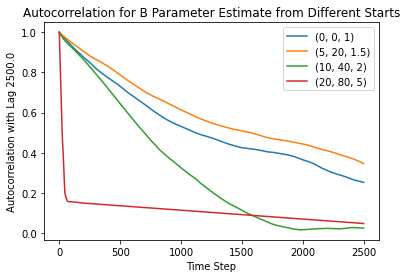

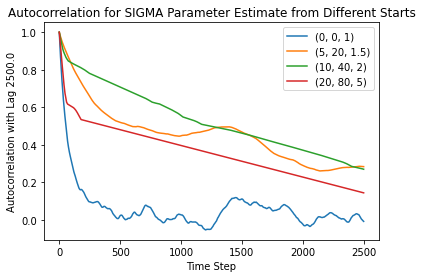

<Figure size 432x288 with 0 Axes>

In [27]:
data = nfl_df[['passing_yards','epa']].dropna().to_numpy()
adaptive_df = compare_convergences([(0,0,1),(5,20,1.5),(10,40,2),(20,80,5)], data, 25000, True, '../results/applied_study/notebook/')